# На основі даних 2 датасетів про A/B тестування, розрахувати основні маркетингові показники та виявити, яка зміна була ефективнішою та принесла більшу прибутковість:
### CTR = кліки на сайті/покази * 100%
### CPC = витрати / кліки на сайті
### CPM = витрати / покази * 1000
### CPA = витрати / кількість покупок
### CR = кількість покупок / кліки на сайті * 100%

## Результати подати в текстовому та графічних виглядах. Сформулювати грунтовні висновки

#### Імпортуємо необхідні бібліотеки

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime

#### Зчитуємо дані та обираємо стовпці які нас цікавлять

In [143]:
data_test_group=pd.read_csv('test_group.csv')
data_control_group=pd.read_csv('control_group.csv')

print(data_control_group)
print(data_test_group)


       Campaign Name   Date  Spend [USD]  # of Impressions   Reach  \
0   Control Campaign  43678         2280             82702   56930   
1   Control Campaign  43679         1757            121040  102513   
2   Control Campaign  43680         2343            131711  110862   
3   Control Campaign  43681         1940             72878   61235   
4   Control Campaign  43682         1835                 0       0   
5   Control Campaign  43683         3083            109076   87998   
6   Control Campaign  43684         2544            142123  127852   
7   Control Campaign  43685         1900             90939   65217   
8   Control Campaign  43686         2813            121332   94896   
9   Control Campaign  43687         2149            117624   91257   
10  Control Campaign  43688         2490            115247   95843   
11  Control Campaign  43689         2319            116639  100189   
12  Control Campaign  43690         2697             82847   68214   
13  Control Campaign

### Переходимо до розрахунку маркетингових показників. Після , запишемо показники в нові файли


In [144]:
def calculate_parameters(df):
   
    # Рассчитываем CTR и добавляем его в новый столбец
    df['CTR'] = (df['# of Website Clicks'] / df['# of Impressions']) * 100
    df['CPC'] = (df['Spend [USD]'] / df['# of Website Clicks'])
    df['CPM'] = (df['Spend [USD]'] / df['# of View Content']) * 1000
    df['CPA'] = (df['Spend [USD]'] / df['# of Purchase'])
    df['CR'] = (df['# of Purchase'] / df['# of Website Clicks'])*100
    df['ROAS'] = (df['# of Purchase'] / df['# of Website Clicks'])*100
    return df

data_control_group = pd.read_csv('control_group.csv')
data_with_ctr = calculate_parameters(data_control_group)
data_with_ctr.to_csv('control_group_with_indicators.csv', index=False)

data_control_group = pd.read_csv('test_group.csv')
data_with_ctr = calculate_parameters(data_control_group)
data_with_ctr.to_csv('test_group_with_indicators.csv', index=False)
print("Файли збережені")

Файли збережені


## Відкриваємо заново файли з показниками. Конвертуємо дату в зручний формат

In [152]:
data_test_group=pd.read_csv('test_group_with_indicators.csv')
data_control_group=pd.read_csv('control_group_with_indicators.csv').iloc[:,:]

base_date = datetime(1900, 1, 1)
data_test_group['Date'] = data_test_group['Date'].apply(lambda x: (base_date + timedelta(days=x-2)).strftime('%d.%m.%Y'))
data_control_group['Date'] = data_control_group['Date'].apply(lambda x: (base_date + timedelta(days=x-2)).strftime('%d.%m.%Y'))

del data_control_group["Unnamed: 10"]
del data_test_group["Unnamed: 10"]

print(data_test_group)
print(data_test_group)

    Campaign Name        Date  Spend [USD]  # of Impressions   Reach  \
0   Test Campaign  01.08.2019         3008             39550   35820   
1   Test Campaign  02.08.2019         2542            100719   91236   
2   Test Campaign  03.08.2019         2365             70263   45198   
3   Test Campaign  04.08.2019         2710             78451   25937   
4   Test Campaign  05.08.2019         2297            114295   95138   
5   Test Campaign  06.08.2019         2458             42684   31489   
6   Test Campaign  07.08.2019         2838             53986   42148   
7   Test Campaign  08.08.2019         2916             33669   20149   
8   Test Campaign  09.08.2019         2652             45511   31598   
9   Test Campaign  10.08.2019         2790             95054   79632   
10  Test Campaign  11.08.2019         2420             83633   71286   
11  Test Campaign  12.08.2019         2831            124591   10598   
12  Test Campaign  13.08.2019         1972             65827   4

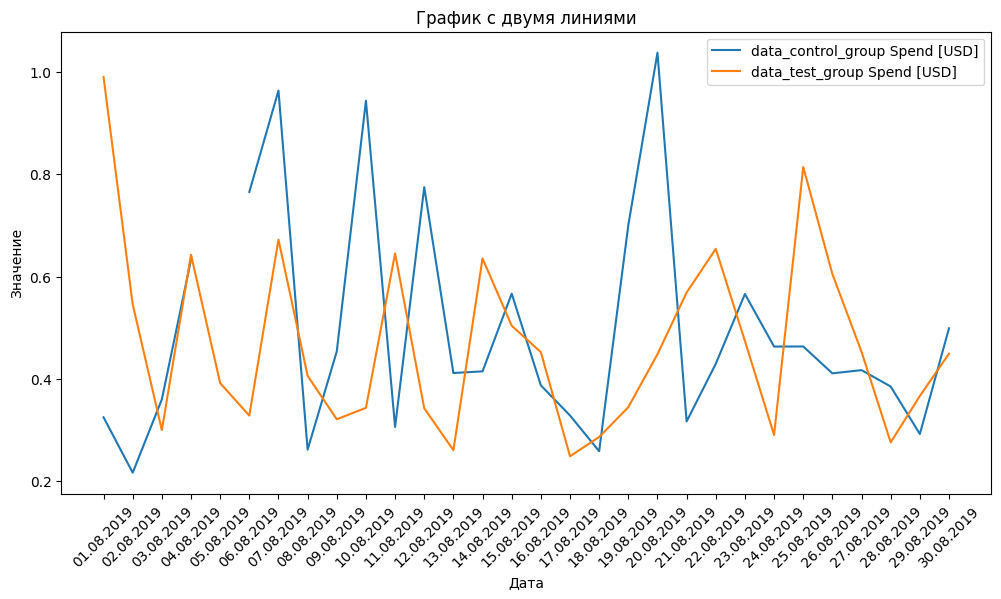

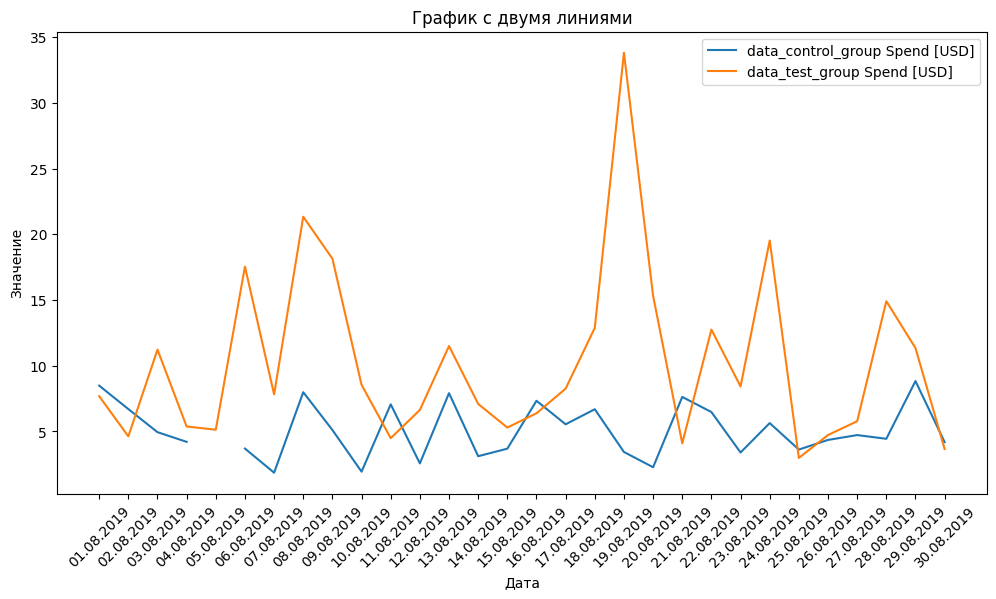

In [157]:
# Если столбец называется 'Date', используем его
x = data_control_group['Date']
y1 = data_control_group['CPC']
y2 = data_test_group['CPC']

plt.figure(figsize=(12, 6)) 
# Создание графика
plt.plot(x, y1, label='data_control_group Spend [USD]')
plt.plot(x, y2, label='data_test_group Spend [USD]')

# Настройки графика
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('График с двумя линиями')
plt.legend()

# Показать график
plt.xticks(rotation=45)  # Если даты отображаются слаборазличимыми


y1 = data_control_group['CTR']
y2 = data_test_group['CTR']
plt.show()

plt.figure(figsize=(12, 6)) 
# Создание графика
plt.plot(x, y1, label='data_control_group Spend [USD]')
plt.plot(x, y2, label='data_test_group Spend [USD]')

# Настройки графика
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('График с двумя линиями')
plt.legend()

# Показать график
plt.xticks(rotation=45)  # Если даты отображаются слаборазличимыми
plt.show()

In [151]:
base_date = datetime(1900, 1, 1)
data_test_group['Date'] = data_test_group['Date'].apply(lambda x: (base_date + timedelta(days=x-2)).strftime('%d.%m.%Y'))

# Перегляд результату


print(data_test_group)


    Campaign Name        Date  Spend [USD]  # of Impressions   Reach  \
0   Test Campaign  01.08.2019         3008             39550   35820   
1   Test Campaign  02.08.2019         2542            100719   91236   
2   Test Campaign  03.08.2019         2365             70263   45198   
3   Test Campaign  04.08.2019         2710             78451   25937   
4   Test Campaign  05.08.2019         2297            114295   95138   
5   Test Campaign  06.08.2019         2458             42684   31489   
6   Test Campaign  07.08.2019         2838             53986   42148   
7   Test Campaign  08.08.2019         2916             33669   20149   
8   Test Campaign  09.08.2019         2652             45511   31598   
9   Test Campaign  10.08.2019         2790             95054   79632   
10  Test Campaign  11.08.2019         2420             83633   71286   
11  Test Campaign  12.08.2019         2831            124591   10598   
12  Test Campaign  13.08.2019         1972             65827   4